## 透過 API 抓取 BTC/USDT 數據

In [1]:
from datetime import datetime, timedelta
import time
today = datetime.now()
edt = time.mktime(today.timetuple())
sdt = time.mktime((today - timedelta(days = 360)).timetuple())
int(sdt), int(edt)

(1580005752, 1611109752)

In [2]:
import requests
api_url = f'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start={sdt}&end={edt}&period=86400'
res = requests.get(api_url)
res

<Response [200]>

In [3]:
import pandas
df = pandas.DataFrame(res.json())

In [4]:
df.head()

date         high          low         open        close  \
0  1580005752  8614.722955  8614.722955  8614.722955  8614.722955   
1  1580083200  9000.000000  8575.674753  8614.722955  8910.588061   
2  1580169600  9398.945746  8895.000000  8909.497177  9383.165804   
3  1580256000  9445.936554  9221.621235  9373.392830  9304.274634   
4  1580342400  9643.916261  9207.110040  9303.307942  9513.103431   

         volume  quoteVolume  weightedAverage  
0  0.000000e+00     0.000000      8614.722955  
1  3.318643e+07  3789.872880      8756.607679  
2  4.060210e+07  4482.190305      9058.540967  
3  2.327623e+07  2490.903054      9344.493698  
4  4.019863e+07  4280.333531      9391.471109

In [5]:
df['date'] = pandas.to_datetime(df['date'], unit = 's')

In [7]:
df.tail()

date          high           low          open         close  \
356 2021-01-16  37950.416083  35253.300000  36757.873926  36011.108674   
357 2021-01-17  36850.000000  33872.688765  36001.800364  35835.931579   
358 2021-01-18  37434.541807  34783.000000  35823.850266  36610.629133   
359 2021-01-19  37839.200194  35871.698969  36623.199035  35894.656128   
360 2021-01-20  36404.870227  35633.412701  35927.021397  35884.492125   

           volume  quoteVolume  weightedAverage  
356  7.337276e+07  1992.367393     36826.924558  
357  4.671074e+07  1317.816063     35445.571859  
358  5.707860e+07  1580.752343     36108.504166  
359  6.666935e+07  1810.323247     36827.316370  
360  9.278198e+06   257.182373     36076.337787

## 計算技術指標
- ! pip install TA-lib

In [8]:
! pip install TA-lib

## 平均移動線
移動平均線計算過去一段時間區間裡的平均成交價格，可以用來判斷趨勢或是預期市場現在跟未來可能的走勢。
- https://rich01.com/what-is-moving-average-line/

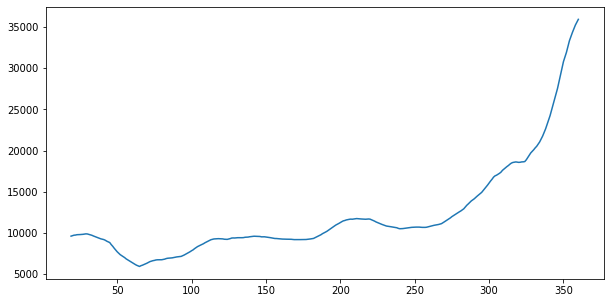

In [9]:
import talib
sma = talib.SMA(df.close, 20)
sma.plot(kind = 'line', figsize = [10,5])

## RSI 指標

RSI指標(英文:Relative Strength Index , RSI)又稱為相對強弱指標， 主要是用來評估股市中「買賣盤雙方力道的強弱」，這是一種技術分析的動量指標， 衡量近期價格變化的幅度，來評估股價超買或超賣情況。

- https://rich01.com/rsi-index-review/

In [10]:
rsi = talib.RSI(df.close, 9)

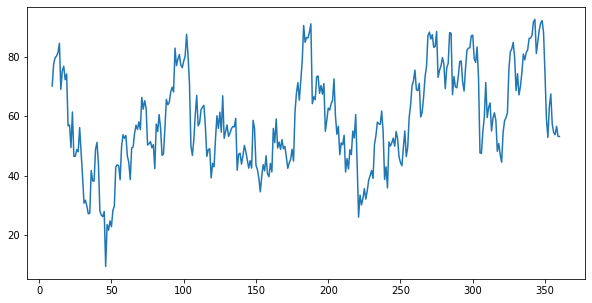

In [11]:
rsi.plot(kind = 'line', figsize = [10,5])

## KD 指標
KD指標(stochastic  oscillator 隨機指標) 作為投資人最喜歡關注的指標之一，該指標常被用來判斷股價強弱、尋找價格反轉點，進而決定進場出場的時機。而KD數值越高代表個股的收盤價接近最近幾天的最高價，反之KD數值越低代表個股的收盤價接近最近幾天的最低價。

- https://www.pfcf.com.tw/product/detail/2624

In [12]:
slowk,slowd = talib.STOCH(df['high'],df['low'],df['close'], fastk_period = 9,slowk_period=3,slowd_period=3)
df['slowK'] = slowk
df['slowD'] = slowd

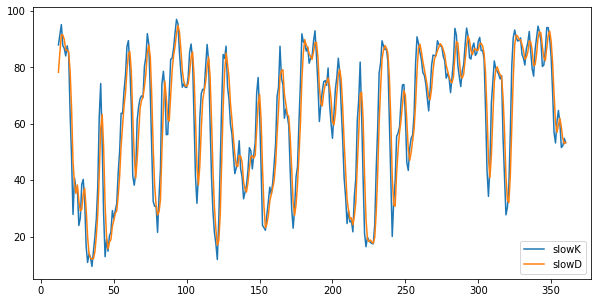

In [13]:
df[['slowK','slowD']].plot(kind = 'line', figsize = [10,5])

## MACD 指標

MACD指標(Moving Average Convergnece & Divergence)中文稱為平滑異同移動平均線指標，股票的技術分析中，會用這個指標來判斷股價走勢，確定波段漲幅並找到買賣點，最常用的值為12天、26天、9天，也稱為MACD(12,26,9)

- https://rich01.com/what-is-macd-indicator/

In [14]:
df['MACD'],df['MACDsignal'],df['MACDhist'] =  talib.MACD(df['close'],fastperiod=12, slowperiod=26, signalperiod=9)

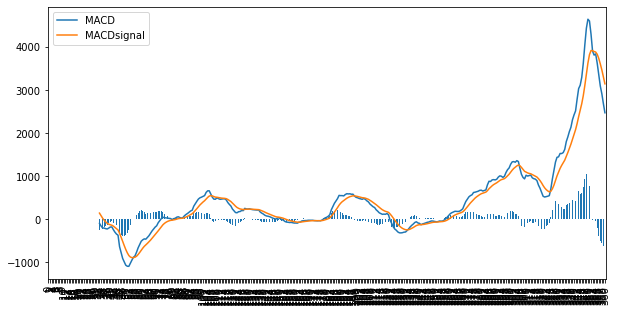

In [15]:
df[['MACD','MACDsignal']].plot(kind = 'line', figsize = [10,5])
df['MACDhist'].plot(kind = 'bar', figsize = [10,5])

## 使用Plotly 彙整所有指標

In [16]:
from plotly import graph_objs as go

trace1 = go.Candlestick(name = 'USDT/BTC',
                x    = df['date'],
                open = df['open'],
                high = df['high'],
                low  = df['low'],
                close= df['close'], yaxis = "y4")

trace2 = go.Scatter(name = 'K9', x=df['date'],y=slowk, mode = 'lines', yaxis = "y3")
trace3 = go.Scatter(name = 'D9',x=df['date'],y=slowd, mode = 'lines', yaxis = "y3")

trace4 = go.Scatter(name ='DIF', x=df['date'],y=df['MACD'], mode = 'lines', yaxis = "y2")
trace5 = go.Scatter(name ='MACD', x=df['date'],y=df['MACDsignal'], mode = 'lines', yaxis = "y2")

trace6 = go.Bar(name ='OSC', x=df['date'],y=df['MACDhist'], yaxis = "y1")

In [17]:
data = go.Data([trace1, trace2, trace3, trace4, trace5, trace6])

layout = {
  "yaxis": {"domain": [0, 0.1]}, 
  "yaxis2": {"domain": [0.1, 0.2]}, 
  "yaxis3": {"domain": [0.2, 0.3]},
  "yaxis4": {"domain": [0.3, 1.0]} , 
  'height': 800

}
fig = go.Figure(data=data, layout=layout)
fig.show()

/Users/davidchiu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  DeprecationWarning,
